# Network Creation

We are tasked with creating the Myobacterium Tuberculosis (Mtb) - Human Macrophage Protein-Protein Interaction Network (PPIN). Networks are important to view how proteins are interacting with each other. We can view how the proteins group and form communities. Once we have that information we can add the Mtb pathogen nodes to see if they bridge particular communities or only affect a particular community.

It has been shown in papers that Mtb interacts with Macrophage proteins. We will first develop the method on the macrophage dataset and then we can carry it over to new cell types afterwards.

We can represent this Network by using the Networkx Python package. This will build network which can be plotted using matplotlib. 

### Methods for doing this:
1. First we have to build the Macrophage DataFrame using datasets from (APID, UniProt, and Atlas Proteins)
2. Once we have the DataFrame built we can then build the protein interaction tuples that Networkx uses to represent edges between proteins.
3. We can pull out important *attributes* that will be used later on when we have built the Network. We can use the *attributes* to color and visualize our our communities within our network. 
4. We need to combine 2 Mtb databases (Phisto & HPIDB). We will pull out the Mtb to Human protein interactions into their appropriate tuples. Once we have the tuples we will run the human proteins against the Macrophage dataframe to only pull out the interactions that are present within the Macrophages. (Since we are only looking at Macrophage data at the moment)
5. Now that we have the Macrophage edges and the Mtb-Macrophage edges we can develop two separate networks. 
    - Macrophage Network (Healthy)
    - Mtb-Macrophage Network (Diseased)
6. Now that we have developed these two networks we can color by attributes and create visually appealing graphs. We can also check to see the base differences between these graphs. (Using Graphlet Kernels)
7. After we have our base statistics we will run Community detection algorithms on the two networks and see how they differ.

## Macrophage Database Design

In [1]:
# First thing is to import the necessary python packages that are needed to create/modify our dataframes
import pandas as pd
import numpy as np
import gzip
import re

In [2]:
# Load in APID data
apid_data = pd.read_table('/Users/andrewpowers/bioinformatics/parisa_project/Network-based-study-of-the-role-of-host-pathogen-interactions/database_files/macrophage/apid/9606_Q1.txt',
                         delimiter='\t')

# Load in UniProt data 
uniprot_data = pd.read_table('/Users/andrewpowers/bioinformatics/parisa_project/Network-based-study-of-the-role-of-host-pathogen-interactions/database_files/macrophage/uniprot/uniprot-homo+sapiens.tab.gz', 
                             delimiter="\t")

# Load in Atlas data
proteinatlas = pd.read_table('/Users/andrewpowers/bioinformatics/parisa_project/Network-based-study-of-the-role-of-host-pathogen-interactions/database_files/macrophage/proteinatlas/proteinatlas_macrophage_genes.tsv',
                            delimiter='\t')

/Users/andrewpowers/miniconda3/envs/network_uo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,14,15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Now that we have all of the dataframes imported we can combine the APID and UniProt on like columns:
- Columns: `UniprotID_{A|B}` DF: APID
- Columns: `Entry` DF: UniProt

It is important that we specify `inner` for the how in `pd.merge()` and also the appropriate `suffixes` so we know what column is associated with what protein.
    

In [3]:
# First Add the info for the first UniprotID_A 
first_pass = pd.merge(apid_data, uniprot_data, how="inner", left_on="UniprotID_A", right_on="Entry")

# Add the Second info for the interacting protein UniprotID_B
full_merge_pass = pd.merge(first_pass, uniprot_data, how="inner", left_on="UniprotID_B", right_on="Entry", suffixes=("_protA", "_protB"))

# Check the head of the merged files
full_merge_pass.shape

(139735, 58)

### Subset the Merged Dataframe

Now that we have a dataframe that has all of the relevant info in it, we can subset the dataframe by a macrophage dataframe that we got from protein atlas.

Why are we doing this?

It is because Mtb enters and interacts with proteins within the Macrophage. 
 https://www.sciencedirect.com/science/article/pii/S1097276518305574?via%3Dihub
 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3867229/

In [4]:
# Compare if full_merge_pass proteins are in proteinatlas df
macrophage_interaction_protein_database = full_merge_pass[(full_merge_pass.UniprotID_A.isin(proteinatlas.Uniprot) | full_merge_pass.UniprotID_B.isin(proteinatlas.Uniprot))]

In [5]:
# We want to get rid of homodimers so lets do that now
macrophage_interaction_protein_database = macrophage_interaction_protein_database[macrophage_interaction_protein_database['UniprotID_A'] != macrophage_interaction_protein_database['UniprotID_B']]

## Pull out Attributes

Now that we have our databases merged, subsetted by Macrophages, and we have cleaned up homodimers lets now pull out important information that will be used to construct our graphs later on.

Important columns to look into are:
- `Subcellular location [CC]_prot{A,B}`
- `Gene ontology (molecular function)_prot{A,B}`


If you look at these columns you will see that the subcellular location is not a clean file and isn't well defined. I will have to do some fancy regex to clean that up and pull out the important information.

In [6]:
# In order for us to pull out this information lets get rid of possible NaNs in the columns we are interseted in
# Lets just set them to unknown for now so they don't interrupt our operations at the moment.
macrophage_interaction_protein_database['Subcellular location [CC]_protA'] = macrophage_interaction_protein_database['Subcellular location [CC]_protA'].fillna('unknown')
macrophage_interaction_protein_database['Subcellular location [CC]_protB'] = macrophage_interaction_protein_database['Subcellular location [CC]_protB'].fillna('unknown')

In [8]:
# Now that we have no more empty data in subcellular location CC_protA,B we can do some regex magic
# First lets pull out key words that we want to pull out 
key_words = r'(Golgi apparatus|Chromosome|Cytoplasm|Nucleus|cytoskeleton|Cell membrane|Membrane|Endoplasmic reticulum membrane|Cytoplasmic vesicle membrane|Apical cell membrane|Endoplasmic reticulum|cilium membrane|Mitochondrion|Lysosome|flagellum membrane|cytosol|trans-Golgi network|Cell projection|autophagosome|Endosome membrane|Cytoplasmic granule|Peripheral membrane protein|Early endosome membrane|Secreted|synapse|nucleoplasm|microtubule organizing center|centrosome|Lipid-anchor|podosome membrane|Secret)'

# create lists that will house the pulled out terms
left_human_locations = list()
right_human_locations = list()

# First we will pull out the protA subcellular locations 
for i in macrophage_interaction_protein_database['Subcellular location [CC]_protA']:
    trimmed_note = re.sub('(.*:\s)*[;\.]*', '', i.split('SUBCELLULAR LOCATION:')[1].split('{')[0] if i != 'unknown' else i)
    next_trim = re.findall(key_words, trimmed_note.strip(' ')) if i != 'unknown' else [i]
    if next_trim == []:
        left_human_locations.append(['unknown'])
    else:
        left_human_locations.append(next_trim)

# Do the samething for ProtB now
for i in macrophage_interaction_protein_database['Subcellular location [CC]_protB']:
    trimmed = re.sub('(.*:\s)*[;\.]*', '', i.split('SUBCELLULAR LOCATION:')[1].split('{')[0] if i != 'unknown' else i)
    trim_next = re.findall(key_words, trimmed.strip(' ')) if i != 'unknown' else [i]
    if trim_next == []:
        right_human_locations.append(['unknown'])
    else:
        right_human_locations.append(trim_next)
        
# Get unique subcellular locations
unique_subcellular = set([x[0] for x in left_human_locations])

In [14]:
# Lets add this data back into the database since it will be nice to have a column that contains this info in a clean manner
macrophage_interaction_protein_database['subcellular_location_clean_ProtA'] = left_human_locations
macrophage_interaction_protein_database['subcellular_location_clean_ProtB'] = right_human_locations


## Mtb Data

Lets take our Mtb data and combine it and pull out the macrophage interactions.

We are going to be using these two databases
- HPIDB
- Phisto

The idea for this project came from a paper: https://www.sciencedirect.com/science/article/pii/S1097276518305574?via%3Dihub

We manually created the edges between the proteins as we could not find the protein interactions in the supplementary.

In [21]:
# Hand created interactions
mtb_paper_edges = [
    ('Rv3705c', 'CDKN2A'),
    ('Rv2074', 'HTATSF1'),
    ('Rv2074', 'CAPZB'),
    ('Rv2074', 'KIAA0196'),
    ('Rv2074', 'VPRBP'),
    ('Rv2074', 'FKBP15'),
    ('Rv2074', 'LTV1'),
    ('Rv2074', 'VCP'),
    ('Rv2074', 'ATG4B'),
    ('Rv2074', 'NSFL1C'),
    ('Rv2074', 'IWS1'),
    ('Rv2074', 'NPM1'),
    ('Rv2074', 'RPLP2'),
    ('Rv2074', 'RPLP0'),
    ('LpqN', 'SF1'),
    ('LpqN', 'ERO1L'),
    ('LpqN', 'NAP1L4'),
    ('LpqN', 'GLT25D1'),
    ('LpqN', 'KIAA0907'),
    ('LpqN', 'SOWAHD'),
    ('LpqN', 'VIPAS39'),
    ('LpqN', 'VPS33B'),
    ('LpqN', 'TNRC6B'),
    ('LpqN', 'FMNL1'),
    ('LpqN', 'DIAPH2'),
    ('LpqN', 'PLOD3'),
    ('LpqN', 'MTHFD1'),
    ('LpqN', 'KCTD5'),
    ('LpqN', 'CBL'),
    ('LpqN', 'C22orf28'),
    ('LpqN', 'DDX1'),
    ('LpqN', 'TARDBP'),
    ('LpqN', 'C14orf166'),
    ('LpqN', 'GIGYF2'),
    ('LpqN', 'YTHDF3'),
    ('LpqN', 'EIF4E2'),
    ('LpqN', 'EIF3C'),
    ('LpqN', 'AGO2'),
    ('LpqN', 'SCYL2'),
    ('Rv1984c', 'HECTD1'),
    ('Rv0999', 'SORBS1'),
    ('EspB', 'HNRNPUL1'),
    ('EspB', 'DAZAP1'),
    ('EspB', 'YTHFD1'),
    ('EspB', 'NUP21'),
    ('EspB', 'NUP88'),
    ('PE35', 'NUP153'),
    ('PE35', 'DYNLL1'),
    ('Rv1906c', 'DHPS'),
    ('Rv1906c', 'GLUL'),
    ('Rv1906c', 'EZR'),
    ('Rv3722c', 'CCT3'),
    ('Rv3722c', 'CCT8'),
    ('Rv3722c', 'CCT4'),
    ('Rv3722c', 'CCT2'),
    ('Rv3722c', 'CCT7'),
    ('Rv3722c', 'CCT6A'),
    ('Rv3722c', 'CCT5'),
    ('PPE11', 'TMED10'),
    ('PPE11', 'MOGS'),
    ('Rv2469c', 'AIMP2'),
    ('Rv2469c', 'RARS'),
    ('Rv2469c', 'EPRS'),
    ('Rv2469c', 'MARS'),
    ('Rv2469c', 'RCN2'),
    ('Rv2469c', 'TIMM13'),
    ('Rv2469c', 'TIMM8A'),
    ('Rv2469c', 'OLA1'),
    ('Rv2469c', 'TUFM'),
    ('Rv2469c', 'DICER1'),
    ('Rv2401', 'RPS3A'),
    ('Rv2401', 'USP11'),
    ('Cfp6', 'RLP13'),
    ('Cfp6', 'IPO5'),
    ('Cfp6', 'IFI30'),
    ('Rv3033', 'NAP1L1'),
    ('Rv3033', 'ZC3H7A'),
    ('Rv3033', 'IL16'),
    ('Rv3033', 'PCBP1'),
    ('Rv3033', 'LASP1'),
    ('Rv3668c', 'HCFC1'),
    ('Rv1498a', 'HNRNPA1'),
    ('Rv1074c', 'RPL22'),
    ('Rv1074c', 'PPP6C'),
    ('Rv1074c', 'DLD'),
    ('Rv1074c', 'RBBP5'),
    ('Rv1074c', 'ASH2L'),
    ('Rv1074c', 'DPY30'),
    ('Rv1074c', 'PPP2R1A'),
    ('Rv1074c', 'PPP2CB'),
    ('Rv1074c', 'PPP2R2A'),
    ('Rv1074c', 'HNRNPK'),
    ('ESAT6', 'RAB1A'),
     ('ESAT6', 'RAB1B'),
     ('ESAT6', 'PPOX'),
     ('ESAT6', 'PGRMC1'),
     ('ESAT6', 'PRC1'),
     ('ESAT6', 'PTGES2'),
     ('TB8.4', 'RAB11B'),
     ('TB8.4', 'RAB5A'),
     ('TB8.4', 'LRRFIP1'),
     ('TB8.4', 'NRAS'),
     ('EsxQ', 'HEATR2'),
     ('EsxQ', 'ACBD3'),
     ('EsxQ', 'DCTPP1'),
     ('EsxQ', 'GCN1L1'),
     ('Apa', 'SFPQ'),
     ('Apa', 'CPSF6'),
     ('Apa', 'NUDT21'),
     ('Apa', 'FUBP3'),
     ('Apa', 'FUBP1'),
     ('Apa', 'DNM2'),
     ('Apa', 'VASP'),
     ('Apa', 'EVL'),
     ('Apa', 'EDC4'),
     ('Apa', 'PAICS'),
     ('Apa', 'KHSRP'),
     ('Apa', 'SEC13'),
     ('Apa', 'SEC23A'),
     ('Apa', 'SEC31A'),
     ('Apa', 'SEC24D'),
     ('Apa', 'SEC23B'),
     ('Apa', 'PTPN23'),
     ('Apa', 'DOK3'),
     ('Apa', 'TRIP6'),
     ('Apa', 'PRRC1'),
     ('Apa', 'RBM12'),
     ('Apa', 'NONO'),
     ('Apa', 'PDCD6IP'),
     ('PE25', 'VAT1'),
     ('PE25', 'NSDHL'),
     ('PE25', 'ACSL4'),
     ('PE25', 'ARL8B'),
     ('PE25', 'BAX'),
     ('Rv2491', 'FAM175B'),
     ('Rv2491', 'SCP2'),
     ('EspR', 'H3F3A'),
     ('EspR', 'FBXW11'),
     ('EspR', 'HIST2H3A'),
     ('EspR', 'XRCC5'),
     ('EspR', 'XRCC6'),
     ('LpqR', 'CDC37'),
     ('Rv1804c', 'TANK'),
     ('Rv1804c', 'TUBG1'),
     ('Rv1804c', 'TGFB1I1'),
     ('Rv1804c', 'ACAP1'),
     ('Rv1804c', 'MZT2B'),
     ('Rv1804c', 'TUBGCP3'),
     ('Rv1804c', 'TUBGCP2'),
     ('Rv1804c', 'DERA'),
     ('Rv1804c', 'ALDH16A1'),
     ('Rv1804c', 'STRN'),
     ('Rv1804c', 'STRN3'),
     ('Rv1804c', 'STRN4'),
     ('Rv1804c', 'MOB4'),
     ('Rv1816', 'USP9X'),
     ('Rv1816', 'KBTBD4'),
     ('Rv1816', 'CSNK2A1'),
     ('Rv1816', 'CSNK2B'),
     ('Rv1816', 'ZC3H18'),
     ('Rv1816', 'FUCA1'),
     ('Rv1816', 'PRKDC'),
     ('Rv1827', 'SRRM1'),
     ('Rv1827', 'SRRM2'),
     ('Rv1827', 'RNPS1'),
     ('Rv1827', 'SRSF2'),
     ('Rv1827', 'AHCYL1'),
     ('Rv1827', 'NACA'),
     ('Rv1827', 'EIF5B'),
     ('Rv1827', 'MCM2'),
     ('Rv1827', 'MCM5'),
     ('Rv1827', 'MCM7'),
     ('Rv1827', 'MCM3'),
     ('Rv1827', 'PTMS'),
     ('Rv1827', 'AP3B1'),
     ('Rv1827', 'BLOC1S1'),
     ('Rv1827', 'UBE2O'),
     ('Rv1827', 'SARNP'),
     ('Rv1827', 'PCM1'),
     ('Rv1827', 'BTF3'),
     ('Rv1498a', 'HNRNPA1'),
     ('Rv3668c', 'HCFC1'),
     ('Rv1075C', 'HNRNPK'),
     ('Rv1075C', 'PPP2R2A'),
     ('Rv1075C', 'PPP2CB'),
     ('Rv1075C', 'PPP2R1A'),
     ('Rv1075C', 'DPY30'),
     ('Rv1075C', 'ASH2L'),
     ('Rv1075C', 'RBBP5'),
     ('Rv1075C', 'DLD'),
     ('Rv1075C', 'PPP6C'),
     ('Rv1075C', 'RPL22')
]

In [22]:
# load in the phisto data
phisto = pd.read_csv('../database_files/mtb/phisto/phi_data.csv')

# load in HPIDB data
hpidb_data = pd.read_table("../database_files/mtb/hpidb/ob8gkx1635827600_s_list.mitab.txt", 
                           delimiter="\t")

## Checking Databases

Lets take the Phisto and HPIDB databases and pull out the overlapping interactions and the unique ones.

In [23]:
# This will house the phisto edges
phisto_list = list()

# Now lets pull out the protein-protein interactions and store them in a tuple into phisto_list
for i in range(0, len(phisto)):
    phisto_list.append((phisto['Uniprot ID'][i], phisto['Uniprot ID.1'][i]))

# When examining the data we see that there are repeats so lets pull out only the unique ones as we don't need duplicates
unique_phisto = list(set(phisto_list))

In [24]:
# the hpidb database has a lot of very messy data, lets pull out only the data we have good Uniprot Identifiers for
uniprot_hpidb = hpidb_data[hpidb_data.protein_xref_1.str.contains('uniprotkb:') | hpidb_data.protein_xref_2.str.contains('uniprotkb:')]

In [35]:
# Now that we have the cleaned dataframe lets pull out the edges
hpidb_edges = list()

# pull out edges
for num in range(0, len(uniprot_hpidb)):
    hpidb_edges.append((uniprot_hpidb.protein_xref_2.iloc[num].strip('uniprotkb:'), uniprot_hpidb.protein_xref_1.iloc[num].strip('uniprotkb:')))

# Grab only the unique ones
unique_hpidb = list(set(hpidb_edges))

In [70]:
# Now lets combine all of the mtb edges into one list
mtb_paper_edges.extend(unique_phisto)
mtb_paper_edges.extend(unique_hpidb)

# Now that we have all of them lets make them unique again since there will be some redundencies
mtb_final_edges = list(set(mtb_paper_edges))

# Create lists to store the mtb and human proteins
mtb_prots = list()
human_prots = list()

# Pull out proteins into their respective list
for i in mtb_final_edges:
    mtb_prots.append(i[0])
    human_prots.append(i[1])

True

In [77]:
# We need to now pull out specific human prots that are found in both the mtb and macrophage
human_in_G = list()
unique_human_from_mtb = list(set(human_prots))
UniA = [i.split('_')[0] for i in macrophage_interaction_protein_database.UniprotName_A]
UniB = [i.split('_')[0] for i in macrophage_interaction_protein_database.UniprotName_B]
for i in unique_human_from_mtb:
    if i in UniA or i in UniB:
        human_in_G.append(i)

# Uniprot ID dict
uniprot_dict = {}

for row in range(0, len(macrophage_interaction_protein_database)):
    uniprot_dict[macrophage_interaction_protein_database.UniprotName_A.iloc[row].split('_')[0]] = macrophage_interaction_protein_database.UniprotID_A.iloc[row]
    uniprot_dict[macrophage_interaction_protein_database.UniprotName_B.iloc[row].split('_')[0]] = macrophage_interaction_protein_database.UniprotID_B.iloc[row]

# Now that I have those specific proteins I should only add those edges
in_dataframe_edges = list()
for match_prot in human_in_G:
    for tuple_set in mtb_final_edges:
        if match_prot in tuple_set:
            new_tuple = (tuple_set[0], uniprot_dict[tuple_set[1]])
            in_dataframe_edges.append(new_tuple)


## Network Graphing

Now that we have all of our data ready to go lets create some networks!
We will be using Networkx as our package to generate these networks.

Lets remind ourselves the datasets that we have.
1. Human Macrophage data
    - macrophage_interaction_protein_database (DF)
2. Mtb Pathogen data
    - in_dataframe_edges (list of tuple(edges))
    
The Mtb data is ready to go as Networkx takes a list of tuples as the input for `.add_edges_from()`. However, we still have the macrophage data in a dataframe format. We need to pull out that information and its attributes and construct our networks.

In [79]:
# Import networkx and matplotlib
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [80]:
# pull out the individual arrays
protA = np.array(macrophage_interaction_protein_database.UniprotID_A)
protB = np.array(macrophage_interaction_protein_database.UniprotID_B)

# Create a list of tuples containing the edge interactions
protein_edges = list()
for i in range(0, len(protA)):
    protein_edges.append((protA[i], protB[i]))

In [81]:
# Now lets create our graphs

# Healthy human macrophage network
healthy = nx.Graph(name='healthy human macrophage network no Mtb')

# Disease macrophage network with Mtb
disease = nx.Graph(name='Diseased macrophage network with Mtb')


# Lets add the macrophage data to both of them.
healthy.add_edges_from(protein_edges)
disease.add_edges_from(protein_edges)

# Lets add the pathogen nodes to the disease network as well
disease.add_edges_from(in_dataframe_edges)

In [82]:
# Lets add our attributes to the nodes
for index in range(0, len(protein_edges)):
    healthy.nodes[protein_edges[index][0]]['location'] = left_human_locations[index]
    disease.nodes[protein_edges[index][0]]['location'] = left_human_locations[index]
    
for index in range(0, len(protein_edges)):
    healthy.nodes[protein_edges[index][1]]['location'] = right_human_locations[index]
    disease.nodes[protein_edges[index][1]]['location'] = right_human_locations[index]
    
# Lets add Mtb to the location for the mtb nodes
mtb_nodes = list()

for node in disease.nodes:
    if node in mtb_prots:
        disease.nodes[node]['location'] = ['Mtb']
        mtb_nodes.append(node)

## Graphing

It is important to set up a couple of things before hand so we they will stay standardized while we make the graphs.
One of those things is the color_map we will be using to color the nodes. We want to color the nodes by subcellular location in this instance. We can do this by creating a dictionary with the key being the location and the value being the color.

In [94]:
# Set the color map
color_map = {'Apical cell membrane': 'red',
             'Cell membrane': 'blue', 
             'Cell projection':'gold',
             'Chromosome': 'brown',
             'Cytoplasm': 'orange',
             'Early endosome membrane': 'palegreen',
             'Endoplasmic reticulum': 'seagreen',
             'Endoplasmic reticulum membrane': 'black',
             'Endosome membrane': 'cyan',
             'Golgi apparatus': 'dodgerblue',
             'Lipid-anchor': 'skyblue',
             'Lysosome': 'yellow',
             'Membrane': 'khaki',
             'Mitochondrion': 'royalblue',
             'Nucleus': 'green',
             'Peripheral membrane protein': 'purple',
             'Secreted': 'crimson',
             'synapse': 'pink',
             'unknown': 'teal',
             'Mtb': 'lime',
             'Secret': 'maroon'
            }

# Lets set up the color and plot_colors variables already as it will be used later on when we are graphing
colors_disease = [node[1]['location'][0] for node in disease.nodes(data=True)]
plot_colors_disease = [color_map[i] for i in colors]

colors_healthy = [node[1]['location'][0] for node in healthy.nodes(data=True)]
plot_colors_healthy = [color_map[i] for i in colors]

Text(0.5, 1.0, 'Colored Disease Macrophage Network w/ Mtb in Lime Green')

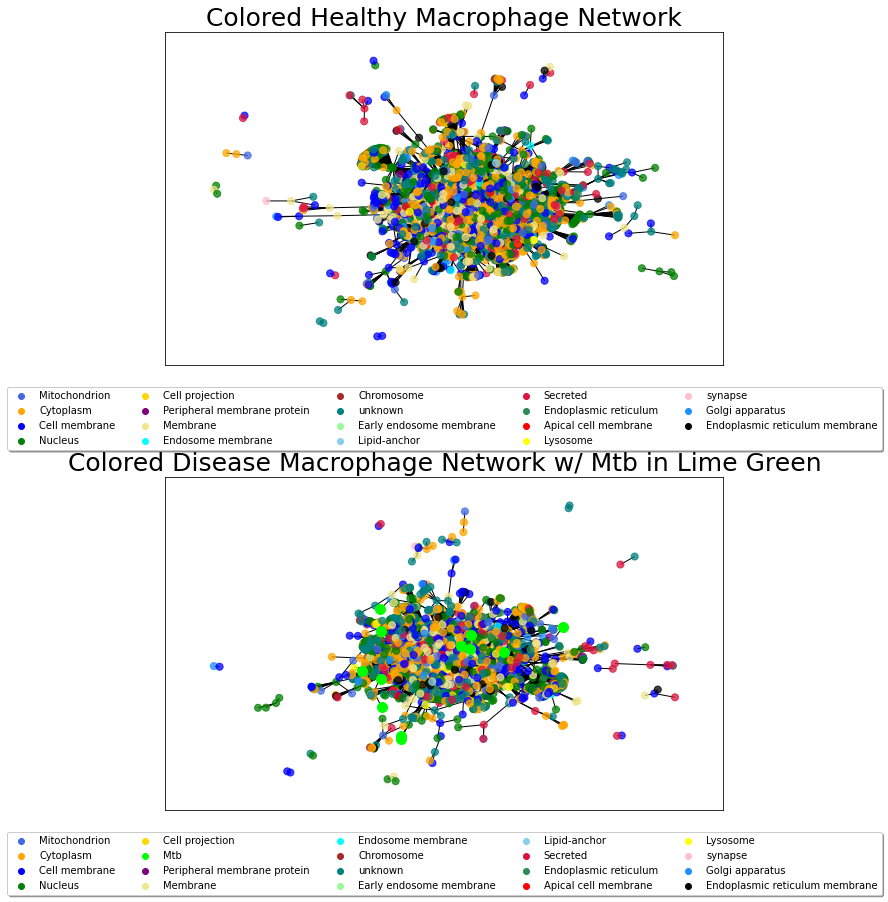

In [103]:
# Set the dimensions of the figure
plt.figure(figsize=(10,15))
plt.tight_layout()


# Lets look at the healthy network first
ax = plt.subplot(2,1,1)
healthy_pos = nx.spring_layout(healthy, iterations=20, seed=205)


# We set the colors of everything specifically using the color map built before
color_health = [color_map[healthy.nodes[x]['location'][0]] for x in healthy.nodes]


# Lets draw all the human nodes
nx.draw_networkx_nodes(healthy,
                      pos=healthy_pos,
                      node_color=color_health,
                      alpha=0.75,
                      node_size=50)

# Lets draw the edges of the graph
nx.draw_networkx_edges(healthy,
                      pos=healthy_pos)

# create scatter plot so I can add a legend
for v in set(colors_healthy):
    plt.scatter([],[], c=color_map[v], label='{}'.format(v))
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

    
# set title and legend location
plt.title('Colored Healthy Macrophage Network', fontsize=25)


# lets draw the disease network
ax = plt.subplot(2,1,2)

# Mtb color set
color_disease = [color_map[disease.nodes[x]['location'][0]] for x in disease.nodes]

disease_pos = nx.spring_layout(disease, iterations=20, seed=201)

# Lets draw the human nodes first
nx.draw_networkx_nodes(disease,
                      pos=disease_pos,
                      node_color=color_disease,
                      alpha=0.75,
                       node_size=50)

# Now lets draw the mtb nodes
nx.draw_networkx_nodes(disease,
                      pos=disease_pos,
                      nodelist=mtb_nodes,
                      node_color='lime',
                      node_size=100)

# draw the edges
nx.draw_networkx_edges(disease, disease_pos)

# Scatter plot so I can have a legend
for v in set(colors_disease):
    plt.scatter([],[], c=color_map[v], label='{}'.format(v))
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

# set title
plt.title('Colored Disease Macrophage Network w/ Mtb in Lime Green', fontsize=25)

# Arranging Node Clusters

Luckily I found a really useful StackOverflow answer here: https://stackoverflow.com/questions/64923687/networkx-drawing-layout-for-multilayer-or-group

The guy mentions being able to group similar attributes togehter using the function below. With a little tweaking we could use it on our data.

In [117]:
def make_node_positions(graph,partition_attr,partition_order=None,epsilon=.5):
    if not partition_order:
        # get a list of all the partition names if not specified
        partition_order = list(set(dict(graph.nodes(data=partition_attr)).values()))
        
    # make position dict for each partition
    orig_partition_pos_dicts = {partition:nx.spring_layout(graph.subgraph([node for node,part in graph.nodes(data=partition_attr) if part[0] == partition])) for partition in partition_order}
    
    # update the x coordinate in the position dicts so partitions
    # don't overlap and are in the specified order left-to-right
    final_pos_dict = orig_partition_pos_dicts[partition_order[0]]
    for i,partition in enumerate(partition_order[1:]):
        # get the largest x coordinate from the previous partition's nodes
        max_previous = max([x for x,y in final_pos_dict.values()])
        # get smallest x coordinate from this partition's nodes
        current_min = min([x for x,y in orig_partition_pos_dicts[partition].values()])
        # update the x coordinates for this partition to be at least epsilon units
        # to the right of the right-most node in the previous partition
        final_pos_dict.update({node:(pos[0]+max_previous+abs(current_min)+epsilon,pos[1])
                                               for node,pos in orig_partition_pos_dicts[partition].items()})
    return(final_pos_dict)

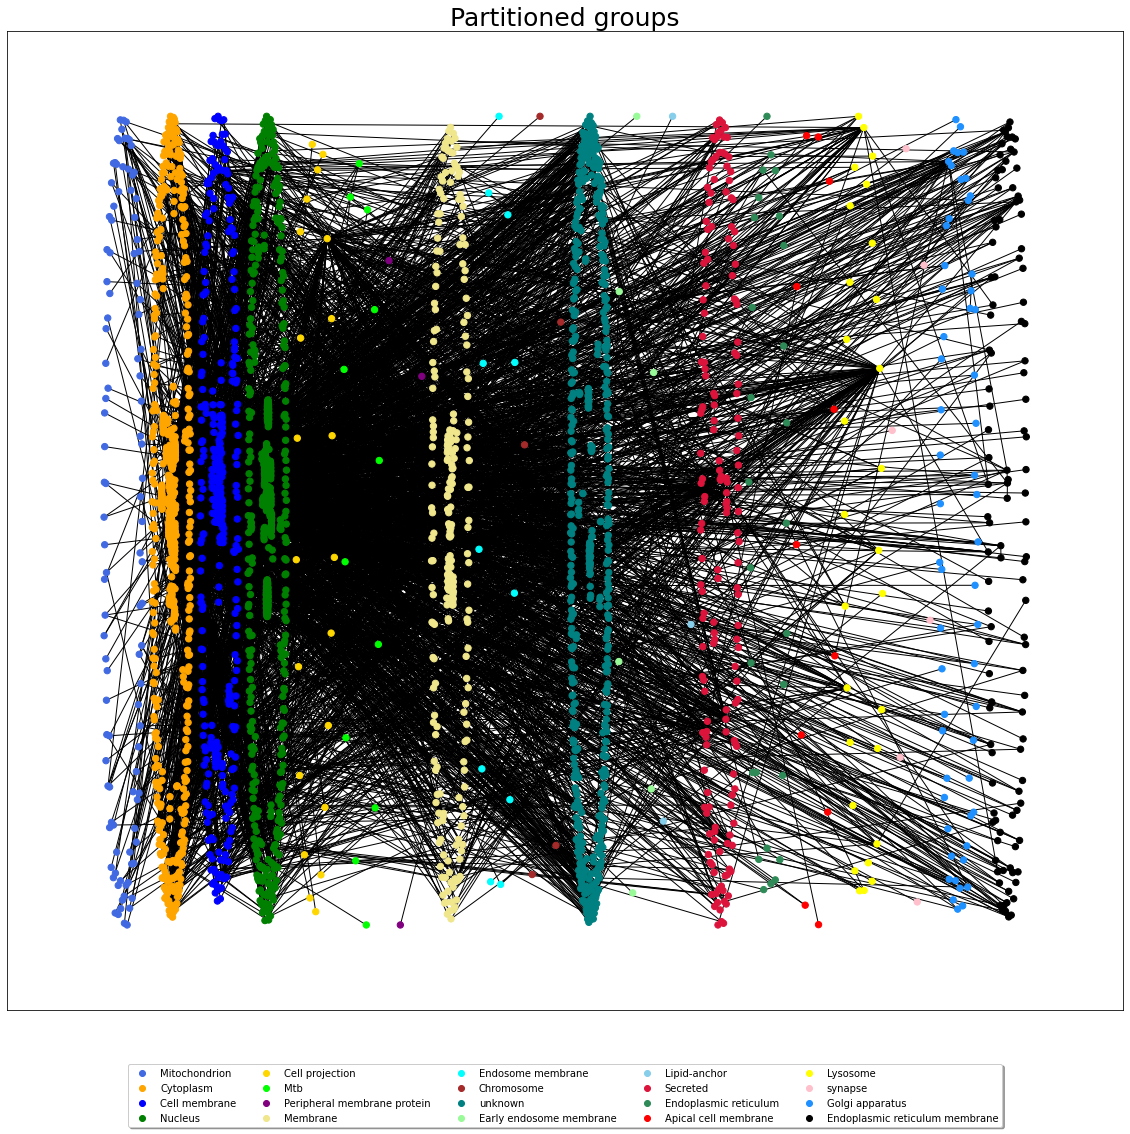

In [122]:
plt.figure(figsize=(20,20))

ax = plt.subplot(111)
# Create the unique partition_order argument
unique_subcellular = list(set([part[0] for node,part in disease.nodes(data='location')]))

# Generate our newly made coords
new_pos = make_node_positions(graph=disease, partition_attr='location', partition_order=unique_subcellular)

# Draw everything
nx.draw_networkx_nodes(disease, new_pos, node_color=color_disease, node_size=40)
nx.draw_networkx_edges(disease, new_pos)


# Scatter plot so I can have a legend
for v in set(colors_disease):
    plt.scatter([],[], c=color_map[v], label='{}'.format(v))
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.title('Partitioned groups', fontsize=25)
plt.show()

## Subgraph 

Lets grab the the nodes that Mtb are directly interacting with and also the children of those nodes and then graph those since it will be a smaller graph and will be much easier to see in general.

In [179]:
# List to hold neighbors
neighbors = list()
child_neighbors = list()

#List to hold edges
full_edge_list = list()

# Now lets pull out their edges/child nodes
for mtb_node in in_dataframe_edges:
    for neighbor_node in disease.edges(mtb_node[0]):
        neighbors.append(neighbor_node[1])
        full_edge_list.append(neighbor_node)

# Lets pull out the child nodes to these child nodes
for child_node in neighbors:
    for child_edges in disease.edges(child_node):
        child_neighbors.append(child_edges[1])
        full_edge_list.append(child_edges)
        
        
# Combine the two neighbor lists now
neighbors.extend(child_neighbors)

# # Create the subgraph
direct_graph = nx.Graph()
direct_graph.add_edges_from(full_edge_list)

In [189]:
# Add back all of the attributes that are in the main graph to the subgraph
for node in direct_graph.nodes:
    direct_graph.nodes[node]['location'] = [disease.nodes[node]['location'][0]]

# Important for the legend production 
unique_subcellular_sub = list(set([part[0] for node,part in direct_graph.nodes(data='location')]))

# Add edges colors to the Mtb nodes and not for any of the other ones
for i in direct_graph.edges():
    if i in in_dataframe_edges:
        direct_graph.edges[i]['color'] = 'red'
    else:
        direct_graph.edges[i]['color'] = 'black'

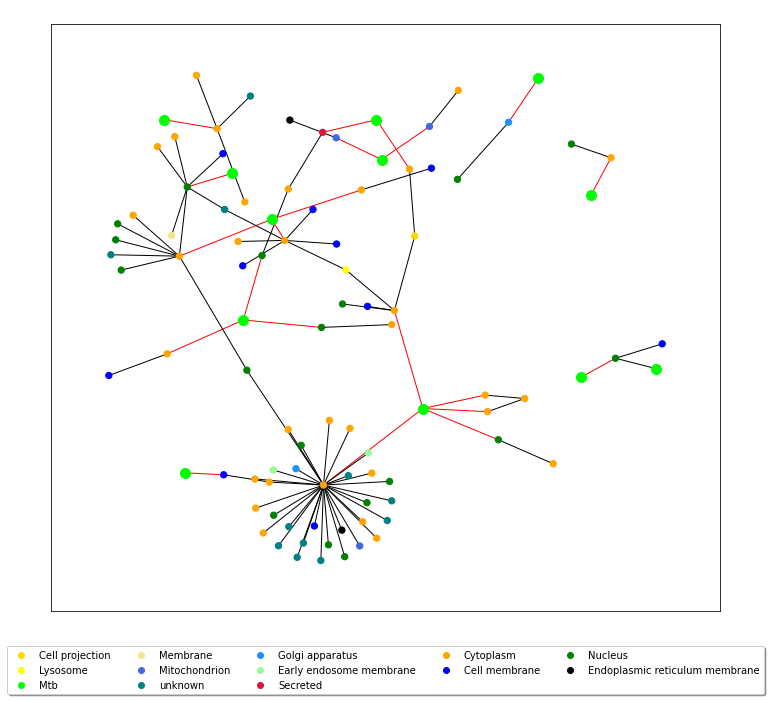

In [208]:
# Set the figure size
plt.figure(figsize=(12,12))

# Set the plot
ax = plt.subplot(111)

# Generate out position
normal_pos = nx.spring_layout(direct_graph, iterations=20, seed=20)

# Generate the colors that will be used
colors_sub = [color_map[direct_graph.nodes[v]['location'][0]] for v in direct_graph.nodes]

# Draw everything
nx.draw_networkx_nodes(direct_graph, normal_pos, node_color=colors_sub, node_size=40)

mtb_sub_nodes = [node for node, part in direct_graph.nodes(data='location') if part[0] == 'Mtb']

# Lets emphasize the Mtb nodes
nx.draw_networkx_nodes(direct_graph, normal_pos, nodelist=mtb_sub_nodes, node_size=100, node_color='lime')

nx.draw_networkx_edges(direct_graph, normal_pos, edge_color=[c for u,v,c in direct_graph.edges(data='color')])


# Scatter plot so I can have a legend
for v in unique_subcellular_sub:
    plt.scatter([],[], c=color_map[v], label='{}'.format(v))
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.title('Mtb connected nodes with children nodes (Mtb is in lime Green)', fontsize=15, color='white')
plt.savefig('/Users/andrewpowers/bioinformatics/parisa_project/Network-based-study-of-the-role-of-host-pathogen-interactions/images/mtb_subgraph_colored.png',
           bbox_inches="tight")